In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
from metrics import compute_wasserstein
from approxRGO import MultiProxSampler
from fabjax.targets.gmm_v0 import GMM
import jax.numpy as jnp
import torch

def init(init_pos, m, dim, rng, sigma):
    return {"x": init_pos, "y_s": init_pos + jnp.sqrt(sigma)*jax.random.normal(rng, shape=(m, dim))}

/Users/lions/Documents/projects/parallelstochasticlocalization/stoloc/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [43]:
dim = 2
batch_size = 1000
m = 4
sigma = 150*jnp.sqrt(m)
alpha = 1
n_runs = 3
rng = jax.random.PRNGKey(0)
init_pos = jnp.zeros(dim)
target = GMM()


In [44]:
run_data = []
for seed in range(n_runs):
    rng = jax.random.PRNGKey(seed)
    log_prob = lambda u, _: target.log_prob(u)
    sampler = MultiProxSampler(log_prob, m, sigma, alpha=alpha)
    init_state = init(init_pos, m, dim, rng, sigma)
    jax_samples = sampler.sample(init_state, rng, batch_size+500)[-batch_size:]
    wass_2 = compute_wasserstein(torch.tensor(np.array(jax_samples)), torch.tensor(np.array(target.sample(rng, batch_size))))
    run_data.append(dict(
        seed=seed,
        wass = wass_2,
        sigma=sigma,
        m = m,
        nll=-float(jnp.mean(target.log_prob(jax_samples))),
    ))

In [45]:
import pandas as pd

df = pd.DataFrame(run_data)
print(df['wass'].mean(), df['wass'].std())
print(df['nll'].mean(), df['nll'].std())

6.506901216901777 0.36296115666411605
6.8024482351893125 0.026457549942556367


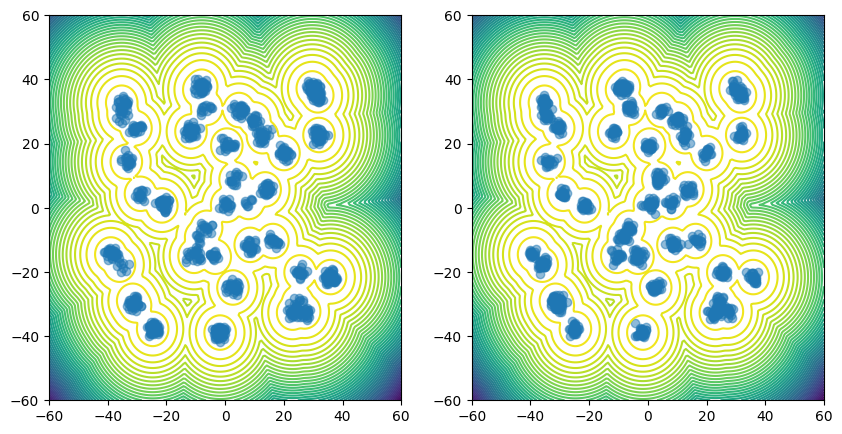

In [46]:
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
from fabjax.targets.gmm_v0 import GMM

target = GMM()
rng = jax.random.PRNGKey(10)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
target.visualise(jax_samples, [ax[0]])
target.visualise(target.sample(rng, 1000), [ax[1]])